In [ ]:
############## Bath parameters ##############
global Boltzmann, hbar, Temp
Boltzmann = 1.0
hbar = 1.0

from concurrent.futures import ProcessPoolExecutor, as_completed
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
import itertools
import os

# Import the outsourced plot settings
from plot_settings import *

In [ ]:
# =============================
# SYSTEM PARAMETERS     (**changeable**)
# =============================
global N_atoms, ODE_Solver, omega_laser, E0, E_freqs, E_amps, omega_A, mu_eg, rabi_0, delta_rabi, Delta, RWA_laser, time_cut, gamma_0, gamma_phi, Gamma
N_atoms = 1  # Set the number of atoms only works for 1
assert N_atoms == 1, "This code only works for 1 atoms"

time_cut = None # time after which the evolution becomes unphysical, to be decided in check_the_solver
fac_two_pi = 1 * 2 * np.pi  # Factor to convert from Hertz to angular frequency [fs^-1] -> [rads/ fs] -> also have to adjust the plotting of the 2D spectrum
RWA_laser = False  #  CAN ONLY HANDLE TRUE For MY solver (paper)   only valid for omega_laser ~ omega_A
ODE_Solver = "BR"  # "MY" (solve the EOMs from the paper) or "BR" do d/dt rho = -i/hbar * [H0 - Dip * E, rho] + R(rho)

gamma_0 = 1/300 # (**changeable**): [1/fs] population. decay rate
T_2 = 1e2       # (**changeable**)     dephasing time
pulse_duration = 1  # [fs]
E0 = 0.1  # (**changeable*) Amplitude of the laser field -> excitation should be <=1%!!!


gamma_phi = 1 / T_2 #               Dephasing rate
Gamma = gamma_0/2 + gamma_phi       # total dephasing rate

### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]

### Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)  # Ground, Excited states
psi_ini = ket2dm(atom_g)  # initial state ground state


# values from the paper: [cm-1] linear wavenumber, usually used in spectroscopy
omega_laser = 16000.0 # in the middle of the two transitions
### If the excited states are coupled -> modified the energy levels
Delta = 200.0
omega_A = 16000.0
mu_eg = 1.0

### define the laser parameters
omega_laser *= fac_two_pi * 3 * 10**-5 #  omega = 2 pi c[10*2 cm/10*15 fs] nu_tilde: [fs⁻¹]
omega_A *= fac_two_pi * 3 * 10**-5
Delta *= fac_two_pi * 3 * 10**-5
print("omega_L, omega_A, Delta", omega_laser, omega_A, Delta)


E_freqs = [omega_laser] * 3  # Laser frequencies
E_amps = [E0, E0, 1e-1 * E0]  # third one is small to simulate a probe field

SM_op = mu_eg * (atom_g * atom_e.dag()).unit()
Dip_op = SM_op + SM_op.dag()

e_ops_list = [
    ket2dm(atom_g),
    atom_g * atom_e.dag(),
    atom_e * atom_g.dag(),
    ket2dm(atom_e),
]
e_ops_labels = ["gg", "ge", "eg", "ee"]

# Rabi oscillation / coupling to the laser
g_value = mu_eg * E0
rabi_0 = g_value / hbar
delta_rabi = omega_laser - omega_A  # detuning from center of manifold
rabi_gen = np.sqrt(
    rabi_0**2 + delta_rabi**2
)

t_max_L = 6 * 2 * np.pi / omega_laser  # Just the six periods of the laser rotation
t_prd = 2 * np.pi / rabi_gen
t_max_r = max(10, 1 * t_prd)  # (**changeable**) # 5 periods of the rabi oscillation
t_max = t_max_r
fine_spacing = .1 * min(t_prd, pulse_duration)
print(fine_spacing)
Delta_ts = [pulse_duration / 2] * 3
print("Period for one Rabi oscillation: T/fs  = ", t_prd)

In [ ]:
# =============================
# FUNCTIONS
# =============================
def get_pulse_args(t0, phi, i):
    """
    Generate pulse arguments based on the current time, phase, and pulse index.

    Parameters:
        t0 (float): Start time of the pulse.
        phi (float): Phase of the pulse.
        i (int): Index of the pulse (0, 1, or 2).

    Returns:
        dict: Dictionary containing pulse parameters.
    """
    return {
        "pulse_phase": phi,  # Phase kick
        "pulse_start_time": t0,  # Start time
        "pulse_freq": E_freqs[i],  # Frequency
        "pulse_half_width": Delta_ts[i],  # Pulse width
        "pulse_amplitude": E_amps[i],  # Amplitude
    }
#CKECKED


def pulse_envelope(t, t0, Delta_width):
    """
    starts at t0, has a width of 2 * Delta_width, and is centered at t0 + Delta_width
    a cos^2 envelope

        Parameters:
        t (float): Time at which the envelope is evaluated.
        t0 (float): Start time of the pulse.
        Delta_width (float): Pulse width parameter.

    Returns:
        float: Envelope value at time t.
    """
    if t < t0 or t > t0 + 2 * Delta_width:
        return 0.0  # Outside the pulse range, envelope is zero
    else:
        return np.cos(np.pi * (t - (t0 + Delta_width)) / (2 * Delta_width)) ** 2
#CKECKED -> TODO not the same as in the paper but okay i guess


# Test function to plot the electric field
def plot_pulse_envelope(times, t0, Delta_width, ax=None):
    """
    Plot the pulse envelope over time.

    Parameters:
        times (array): Array of time values.
        t0 (float): Start time of the pulse.
        Delta_width (float): Pulse width parameter.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. Defaults to None.

    Returns:
        ax (matplotlib.axes.Axes): Axes object with the plot.
    """
    envelope = [pulse_envelope(t, t0, Delta_width) for t in times]
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        times,
        envelope,
        label=r"$\text{Envelope}$",
        linestyle="dotted",
        alpha=0.6,
        color="C0",
    )  # Semi-transparent line
    ax.plot(
        times, envelope, linestyle="dotted", alpha=0.6, color="C0"
    )  # Semi-transparent line
    ax.axvline(
        t0, linestyle="dashed", label=r"$t_0$", alpha=0.4, color="C1"
    )  # Start time
    ax.axvline(
        t0 + Delta_width, linestyle="dashdot", label=r"$t_0 + \Delta$", alpha=0.6, color="C2"
    )  # Midpoint
    ax.axvline(
        t0 + 2 * Delta_width,
        linestyle="dashed",
        label=r"$t_0 + 2\Delta$",
        alpha=0.4,
        color="C1",
    )  # End time
    return ax
#CKECKED plot_pulse_envelope(times, 0, times[-1]/3)


def E_pulse(t, args):
    """
    Define a time-dependent electric field pulse with envelope.

    Parameters:
        t (float): Time at which the electric field is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - "pulse_start_time": Start time of the pulse.
            - "pulse_half_width": Pulse width parameter.
            - "pulse_freq": Frequency of the pulse.
            - "pulse_phase": Phase of the pulse.
            - "pulse_amplitude": Amplitude of the pulse.

    Returns:
        complex: Electric field value at time t.
    """
    t0 = args["pulse_start_time"]  # Start time of the pulse
    Delta = args["pulse_half_width"]  # Pulse width
    phi = args["pulse_phase"]  # Phase
    E0 = args["pulse_amplitude"]  # Amplitude

    ### Calculate the pulse envelope
    Env = pulse_envelope(t, t0, Delta)
    E = np.exp(-1j * phi)  # Simplified electric field under RWA of the paper
    return E0 * Env * E # / 2 # 2 because cos(wt) = (e^(iwt) + e^(-iwt)) / 2
#CKECKED


def Epsilon_pulse(t, args):
    """
    Define a time-dependent electric field pulse with envelope.

    Parameters:
        t (float): Time at which the electric field is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - "pulse_start_time": Start time of the pulse.
            - "pulse_half_width": Pulse width parameter.
            - "pulse_freq": Frequency of the pulse.
            - "pulse_phase": Phase of the pulse.
            - "pulse_amplitude": Amplitude of the pulse.

    Returns:
        complex: Electric field value at time t.
    """
    omega = args["pulse_freq"]  # Frequency

    E = E_pulse(t, args)
    rotation = np.exp(-1j * omega * t)  # General case

    return E * rotation
#CKECKED


def plot_Epsilon_pulse(times, args):
    """
    Plot the electric field pulse over time.

    Parameters:
        times (array): Array of time values.
        args (dict): Dictionary containing pulse parameters.

    Returns:
        None
    """
    t0       = args["pulse_start_time"]
    Delta_width    = args["pulse_half_width"]
    E0       = args["pulse_amplitude"]
    Epsilon_pulse_data = [
        np.real(Epsilon_pulse(t, args) + np.conj(Epsilon_pulse(t, args))) / E0
        for t in times
    ]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        times,
        Epsilon_pulse_data,
        linestyle="solid",
        label=r"$E_{\text{Pulse}}(t) / E_0$",
        color="C3",
    )
    ax = plot_pulse_envelope(times, t0, Delta_width, ax=ax)

    ax.set_xlabel(r"$t \, [\text{fs}]$")
    ax.set_ylabel(r"$f(t)$")
    ax.set_title(
        r"$\text{Electric Field Pulse}$"
        + f"\n$\\phi={args['pulse_phase']:.2f}$, $t_0={t0:.2f}$, "
        + f"$\\omega_L={args['pulse_freq']:.3f}$, $\\Delta={Delta_width:.2f}$, "
        + f"$E_{{0}}={E0:.2f}$"
    )
    ax.legend(
        loc="center left", bbox_to_anchor=(1, 0.5)
    )  # OLD .legend(loc="upper right")
    plt.show()
#CKECKED plot_Epsilon_pulse(times, test_args)


def get_tau_cohs_and_t_dets_for_T_wait(T_wait, spacing = fine_spacing):
    """
    Calculate the time arrays for tau_coh and t_det based on the waiting time T_wait and spacing.

    Parameters:
        T_wait (float): Waiting time.
        spacing (float): Time spacing.

    Returns:
        tuple: Arrays for coherence and detections times tau_coh and t_det.
        both have the same len(_)
    """
    ### Calculate the first and last entries for tau_coh times
    tau_coh_0 = Delta_ts[0] + Delta_ts[1] # the first two pulses directly in succession
    tau_coh_max = (
        np.floor((t_max - Delta_ts[2] - T_wait - Delta_ts[0]) / spacing + 1) * spacing
    ) # the last two pulses directly in succession and then immediatly measure at t_max
    times_tau = np.arange(tau_coh_0, tau_coh_max, spacing) # tau_coh_max is not included!

    ### Calculate the first and last entries for t_det times
    #just reversed arumentation of tau_coh
    t_det_0 = Delta_ts[2] # see tau_coh_max
    t_det_max = (
        np.floor((t_max - Delta_ts[0] - tau_coh_0 - T_wait) / spacing + 1) * spacing
    ) # see tau_coh_0
    times_t = np.arange(t_det_0, t_det_max, spacing) # t_det_max is not included!

    return times_tau, times_t
#CKECKED


# =============================
# SYSTEM / INTERACTION HAMILTONIAN
# =============================
def Hamilton_tls(omega_A):
    """Hamiltonain of a two-level system.

    Args:
        hbar (float): reduced Planck's constant
        omega_A (float): atomic energy 

    Returns:
        Qobj: Hamiltonian operator of the two-level system
    """
    H0 = hbar * omega_A * ket2dm(atom_e)
    return H0
#CKECKED


# Get the full system Hamiltonian with the interaction Hamiltonian, with and with (adjustable) Rotating Wave Approximation (RWA)
def H_int(t, args):
    """
    Define the interaction Hamiltonian for the system.

    Parameters:
        t (float): Time at which the interaction Hamiltonian is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - "pulse_amplitude": Amplitude of the electric field.
            - Other parameters required for the electric field pulse.

    Returns:
        Qobj: Interaction Hamiltonian at time t.
    """
    # Compute the electric field term
    E_field = E_pulse(t, args) if RWA_laser else Epsilon_pulse(t, args)
    
    return -Dip_op * (E_field + np.conj(E_field))
#CKECKED



# # =============================
# ODE SOLVER FOR EQS OF PAPER
# =============================
def R_paper():
    """including RWA
    Constructs the Redfield Tensor R for the equation drho_dt = -i(Hrho - rho H) + R * rho,
    where rho is the flattened density matrix.
    """
    R = np.zeros((4, 4), dtype=complex)
    # Indices for the flattened density matrix:
    # 0: rho_gg, 1: rho_ge, 2: rho_eg, 3: rho_ee

    # --- d/dt rho_eg ---
    R[2, 2] = -Gamma  # Decay term for coherence
    # --- d/dt rho_ge ---
    if not RWA_laser:
        R[1, 1] = R[2, 2]

    # --- d/dt rho_ee ---
    R[3, 3] = -gamma_0  # Decay term for population
    # --- d/dt rho_gg ---
    R[0, 3] =  gamma_0  # TODO THIS IS ACTUALLY NOT THE EQ OF MOTION OF THE PAPER but to ensure trace conservation

    return Qobj(R, dims=[[[2], [2]], [[2], [2]]])
#(CKECKED)-> TODO the equations are weird


def matrix_ODE_paper(t, args):
    """including RWA.
    Constructs the matrix L(t) for the equation drho_dt = L(t) * rho,
    where rho is the flattened density matrix.
    """
    Et = E_pulse(t, args)
    Et_conj = np.conj(Et)

    L = np.zeros((4, 4), dtype=complex)

    # Indices for the flattened density matrix:
    # 0: rho_gg, 1: rho_ge, 2: rho_eg, 3: rho_ee

    ### Diagonals
    # --- d/dt rho_ee ---
    L[3, 3] = -gamma_0
    L[3, 1] = 1j * Et * mu_eg
    L[3, 2] = -1j * Et_conj * mu_eg
    
    # --- d/dt rho_gg ---
    #L[0, 1] = -1j * Et * mu_eg
    #L[0, 2] = 1j * Et_conj * mu_eg
    L[0, :] += -1 * np.sum(L[[3], :], axis=0) # TODO THIS IS ACTUALLY NOT THE EQ OF MOTION OF THE PAPER but it enforces trace conservation
    # print("the trace d/dt (rho_gg + rho_ee) = ", np.sum(L[[0, 3], :]), "should be 0")

    # --- d/dt rho_eg ---
    L[2, 2] = -Gamma  # Decay term for coherence
    L[2, 0] = 1j * Et * mu_eg
    L[2, 3] = -1j * Et * mu_eg

    # --- d/dt rho_ge ---
    if not RWA_laser:
        L[1, 1] = L[2, 2].conj()

    return Qobj(L, dims=[[[2], [2]], [[2], [2]]])
#(CKECKED)-> TODO the equations are weird


def Liouville(args):
    return QobjEvo(matrix_ODE_paper, args)
#CKECKED


In [ ]:
### Calculations to compute one 2D polarization
def compute_pulse_evolution(psi_ini, times, phi, i, omega_at=omega_A):
    """
    Compute the evolution of the i-th pulse starting from the current state psi_ini.
    times[0] =^= psi_ini

    Parameters:
        psi_ini (Qobj): Initial quantum state.
        times (array): Time array for the evolution.
        phi (float): Phase kick for the pulse.
        i (int): Index of the pulse (0, 1, or 2).

    Returns:
        Qutip(Result): Result of the evolution.
    """

    ### Set options for the solver
    progress_bar = (
        "enhanced" if i == 2 else ""
    )  # Enhanced progress bar for the last pulse
    options = {
        "store_states": True,
        "progress_bar": progress_bar,
    }  # Store states for further analysis

    ### Get pulse arguments
    args = get_pulse_args(times[0], phi, i)

    ### Choose solver and compute the evolution
    if ODE_Solver == "MY": # works only with on resonant laser
        L = Liouville(args) # d_dt_rho = L * rho_t

        result = mesolve(
            L,
            psi_ini,
            times,
            options=options,
        )

    ### Choose solver and compute the evolution
    if ODE_Solver == "BR":
        H = Hamilton_tls(omega_A=omega_at) + QobjEvo(H_int, args) # can handle different atomic frequencies
        result = mesolve(
            H,
            psi_ini,
            times,
            c_ops=[R_paper()],
            options=options,
        )
        # TODO split the time evolution into two parts: just for a little speedup
        # 1. the pulse (t0) to (t0 + 2 * Delta)
        # 2. free evolution (t0 + 2 * Delta) to t_max 
        # combine the results 

    return result
#CHECKED



def Plot_evo_1_pulse(data,  e_ops=e_ops_list):
    """
    Plot the evolution of the calculations from compute_pulse_evolution.

    Parameters:
        data (qutip.Result): Results of the pulse evolution.

    Returns:
        None
    """
    ### Update states with RWA phase factors if RWA_laser is True (see get_expect_vals_with_RWA)
    expect_vals_list = get_expect_vals_with_RWA(data.states, data.times, e_ops=e_ops_list, omega=omega_laser)   
    times_evo = data.times

    ### Create subplots
    fig, axs = plt.subplots(len(e_ops), 1, figsize=(15, 10), sharex=True)

    ### Loop over the datas and plot each expectation value
    for idx, expect_vals in enumerate(expect_vals_list):
        axs[idx].plot(times_evo, expect_vals, color=f"C0", linestyle="solid")
        axs[idx].set_ylabel(rf"$|\text{{{e_ops_labels[idx]}}}|^2$")
    axs[0].plot(
        [], [], label=str(ODE_Solver), color="C0", linestyle="solid"
    )  # Add a dummy plot for the legend
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel(r"$t \, [\text{fs}]$")
    plt.show()
#CHECKED
# times = np.arange(0, t_max, fine_spacing)  # High-resolution times array to do the evolutigons
# dest_data = compute_pulse_evolution(psi_ini, times, 0, 0)
# Plot_evo_1_pulse(dest_data)


def apply_RWA_phase_factors(rho, t, omega=omega_laser):
    """
    Apply time-dependent Rotating Wave Approximation phase factors to the density matrix entries.

    Parameters:
        rho (Qobj): Density matrix (Qobj) to modify.
        omega (float): Frequency of the phase factor.
        t (float): Current time.

    Returns:
        Qobj: Modified density matrix with phase factors applied.
    """
    # Extract the density matrix as a NumPy array
    rho_array = rho.full()
    # print(rho.isherm)

    # Apply the phase factors to the specified elements
    phase_1 = np.exp(-1j * omega * t)  # e^(-i * omega * t)

    # Modify the elements
    rho_array[1, 0] *= phase_1  # rho_eg = sigma_eg * e^(-i * omega * t)
    rho_array[0, 1] *= np.conj(phase_1)

    rho_result = Qobj(rho_array, dims=rho.dims)

    return rho_result
#CKECKED


def get_expect_vals_with_RWA(states, times, e_ops=e_ops_list, omega=omega_laser):
    """
    Calculate the expectation values in the result with RWA phase factors.

    Parameters:
        states= data.states (where data = qutip.Result): Results of the pulse evolution.
        times (list): Time points at which the expectation values are calculated.
        e_ops (list): the operators for which the expectation values are calculated
        omega (float): omega_laser (float): Frequency of the laser.
    Returns:
        list of lists: Expectation values for each operator of len(states).
    """
    if RWA_laser:
        # Apply RWA phase factors to each state
        states[:] = apply_RWA_phase_factors(states[:], times[:], omega)

    updated_expects = [np.real(expect(states, e_op)) for e_op in e_ops]
    
    return updated_expects
#CKECKED


def check_the_solver(psi_ini, times, e_ops_list):
    """
    Checks the solver within the compute_pulse_evolution function
    with the provided psi_ini, times, and e_ops_list.

    Parameters:
        psi_ini (qutip.Qobj): Initial quantum state.
        times (numpy.ndarray): Time array for the evolution.
        e_ops_list (list of qutip.Qobj): List of expectation value operators.

    Returns:
        None: Prints the results of the checks.  Raises exceptions on errors.
    """
    print(f"Checking '{ODE_Solver}' solver ")

    # 1. Input Validation
    # ----------------------
    if not isinstance(psi_ini, qutip.Qobj):
        raise TypeError("psi_ini must be a qutip.Qobj")
    if not isinstance(times, np.ndarray):
        raise TypeError("times must be a numpy.ndarray")
    if not isinstance(e_ops_list, list) or not all(isinstance(op, qutip.Qobj) for op in e_ops_list):
        raise TypeError("e_ops_list must be a list of qutip.Qobj")

    if len(times) < 2:
        raise ValueError("times must have at least two elements")

    # 2. Set up the solver call
    # ---------------------------------------
    i = 0  # Example pulse index
    phi = 0.0  # Example phase

    # 3. Call the function to be checked
    # ----------------------------------
    result = compute_pulse_evolution(psi_ini, times, phi, i)

    # 4. Check the result (basic checks)
    # ----------------------------------
    if not isinstance(result, qutip.Result):
        raise TypeError("Result must be a qutip.Result object")

    # Add more specific checks as needed for your implementation
    if result.times != list(times):
        raise ValueError("Result times do not match input times")

    if len(result.states) != len(times):
        raise ValueError("Number of output states does not match number of time points")
    
    # 5. Check if density matrix is Hermitian, positive, and trace-preserving
    # ------------------------------------------------------
    strg = ""
    for index, state in enumerate(result.states):
        if RWA_laser:
            state = apply_RWA_phase_factors(state, times[index], omega=omega_laser)
        time = times[index]
        if not state.isherm:
            strg += f"Density matrix is not Hermitian after t = {time}.\n"
        eigvals = state.eigenenergies()
        #print(eigvals)
        if not np.all(eigvals >= -1e-3):  # allow for small numerical negative eigenvalues
            strg += f"Density matrix is not positive semidefinite after t = {time}: The lowest eigenvalue is {eigvals.min()}.\n"
            time_cut = time
        if not np.isclose(state.tr(), 1.0):
            strg += f"Density matrix is not trace-preserving after t = {time}: The trace is {state.tr()}.\n "
            time_cut = time
        if strg:
            strg += "Adjust your parameters!"
            break
        print(strg) # raise ValueError(strg)
    else: print("Checks passed. solver appears to be called correctly, and density matrix remains Hermitian and positive.")

    return result
#CKECKED



def plot_positive_color_map(
    datas,
    T_wait=np.inf,
    space="real",
    type="real",
    output_dir=None,
    ODE_Solver=None,
    positive=False,
    safe=False,
    use_custom_colormap=False,
    section = None, # tuple of (x_min, x_max, y_min, y_max)
):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        datas (tuple): Tuple containing (x, y, data) where x and y are 1D arrays and data is a 2D array.
        T_wait (float): waiting time to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use ONLY positive values of x and y.
        safe (bool): If True, saves the plot to a file.
        output_dir (str, optional): Directory to save the plot.

    Returns:
        None
    """
    # Ensure datas is a tuple with (x, y, data)
    if not isinstance(datas, tuple) or len(datas) != 3:
        raise ValueError("datas must be a tuple of (x, y, data)")

    # ts, taus, data
    x, y, data = datas

    # Validate that x, y, and data are numpy arrays
    x = np.array(x)
    y = np.array(y)
    data = np.array(data)

    # Check if data dimensions match x and y
    if data.shape[1] != len(x):
        raise ValueError(
            f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]})."
        )
    if data.shape[0] != len(y):
        raise ValueError(
            f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]})."
        )


    if space != "real" and space != "freq":
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")
    elif space == "real":
        colormap = "viridis"
        title = r"$\text{Real space}$"
        x_title = r"$t_{\text{det}}$ [fs]"
        y_title = r"$\tau_{\text{coh}}$ [fs]"
    elif space == "freq": 
        colormap = "plasma"
        title = r"$\text{Freq space}$"
        x_title = r"$\omega_{t_{\text{det}}}$ [$10^4$ cm$^{-1}$]"
        y_title = r"$\omega_{\tau_{\text{coh}}}$ [$10^4$ cm$^{-1}$]"
        

    if type != "real" and type != "imag" and type != "abs" and type != "phase":
        raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")    
    elif type == "real":
        title += r"$\text{, Real 2D Spectrum}$"
        data = np.real(data)
    elif type == "imag":
        title += r"$\text{, Imag 2D Spectrum}$"
        data = np.imag(data)
    elif type == "abs":
        title += r"$\text{, Abs 2D Spectrum}$"
        data = np.abs(data)
        use_custom_colormap = False
    elif type == "phase":
        title += r"$\text{, Phase 2D Spectrum}$"
        data = np.angle(data)

    if T_wait != np.inf:
        title += rf"$\ \text{{at }} T = {T_wait:.2f}$"

    # Filter for positive x and y values if requested
    if positive:
        positive_x_indices = np.where(x > 0)[0]
        positive_y_indices = np.where(y > 0)[0]
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]
    # plot only a small portion of the data
    if section is not None:
        x_min, x_max, y_min, y_max = section
        x_indices = np.where((x >= x_min) & (x <= x_max))[0]
        y_indices = np.where((y >= y_min) & (y <= y_max))[0]
        x = x[x_indices]
        y = y[y_indices]
        data = data[np.ix_(y_indices, x_indices)]

    if use_custom_colormap:
        data_normalized = data
        vmin            = np.min(data_normalized)
        vmax            = np.max(data_normalized)
        vcenter         = 0

        # Create a colormap that forces zero values to white
        cmap = plt.get_cmap("bwr")
        colors = cmap(np.linspace(0, 1, 256))
        mid = 128  # Middle index
        colors[mid] = [1, 1, 1, 1]  # Pure white in RGBA
        colormap = LinearSegmentedColormap.from_list("white_centered", colors)

        # Ensure vmin, vcenter, and vmax are in ascending order
        if vmin > vmax:
            raise ValueError("vmin cannot be greater than vmax. Check your data.")

        # Create the TwoSlopeNorm with corrected values
        norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    else:
        norm = None

    # Set the colorbar label
    cbarlabel = r"$\propto E_{\text{out}} / E_{0}$"

    # Plot the color map
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(
        x, y, data,
        shading="auto",
        cmap=colormap,
        norm=norm,
    )
    plt.colorbar(label=cbarlabel)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True and output_dir is provided
    if safe and output_dir is not None:
        assert os.path.isdir(
            output_dir
        ), f"Output directory {output_dir} does not exist."

        filename_parts = [
            f"M={N_atoms}",
            f"mua={mu_eg:.0f}",
            f"E0={E0:.2e}",
            f"wa={omega_A:.2f}",
            f"wL={omega_laser / omega_A:.1f}wa",
            f"rabigen={rabi_gen:.2f}= sqrt({rabi_0:.2f}^2+{delta_rabi:.2f}^2)",
            f"pos={positive}",
            f"space={space}",
        ]

        if ODE_Solver == "MY":
            filename_parts.append(f"MY")

        if space == "freq":
            filename_parts.append(f"type_{type}")

        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)
    else:
        print("Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.")
    plt.show()
#CKECKED

def El_field_3_pulses(times_0, times_1, times_2, phi_1, phi_2):
    """
    Calculate the combined electric field and time ranges for three pulses.

    Parameters:
        times_0 (array): Time range for the first pulse.
        times_1 (array): Time range for the second pulse.
        times_2 (array): Time range for the third pulse.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.

    Returns:
        tuple: Combined time range (times_plot) and electric field (E_total).
    """
    ### Define pulse arguments
    args0 = get_pulse_args(times_0[0], phi_1, 0)
    args1 = get_pulse_args(times_0[-1], phi_2, 1)
    args2 = get_pulse_args(times_1[-1], 0, 2)

    ### Calculate the electric fields for each time range
    E_1 = [
        (
            np.real(Epsilon_pulse(t, args0) + np.conj(Epsilon_pulse(t, args0)))
            / E0
        )
        for t in times_0
    ]
    E_2 = [
        (
            np.real(Epsilon_pulse(t, args1) + np.conj(Epsilon_pulse(t, args1)))
            / E0
        )
        for t in times_1
    ]
    E_3 = [
        (
            np.real(Epsilon_pulse(t, args2) + np.conj(Epsilon_pulse(t, args2)))
            / E0
        )
        for t in times_2
    ]

    ### Combine time ranges and electric fields
    E_total    = E_1 + E_2 + E_3
    times_plot = np.concatenate([times_0, times_1, times_2])

    return times_plot, E_total
#CKECKED


def Plot_example_evo(
    times_0, times_1, times_2,
    datas,
    phi_1,
    phi_2,
    tau_coh,
    T_wait,
    idx_tau_coh,
):
    """
    Plot the evolution of the electric field and expectation values for a given tau_coh and T_wait.

    Parameters:
        times_0, times_1, times_2 (array): Time ranges for the three pulses.
        T_wait (float): Waiting time.
        tau_coh (float): Coherence time.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.
        data_1, data_2, data_f (qutip.Result): Results of the three pulses.
        idx_tau_coh (int): Indices for the coherence time.

    Returns:
        None
    """
    times_plot, E_total = El_field_3_pulses(times_0, times_1, times_2, phi_1, phi_2)
    ### Create subplots
    fig, axs = plt.subplots(len(datas) + 1, 1, figsize=(15, 10), sharex=True)

    ### Plot the electric field
    axs[0].plot(
        times_plot,
        E_total,
        color="C0",
        linestyle="solid",
    )
    axs[0].set_ylabel(r"$E(t) / E_0$")  # normalize to the first pulse amplitude
    axs[0].axvline(
        times_0[0] + Delta_ts[0], color="C1", linestyle="dashed", label="Pulse 1"
    )  # Mark Pulse 1
    axs[0].axvline(
        times_0[idx_tau_coh] + Delta_ts[1], color="C2", linestyle="dashdot", label="Pulse 2"
    )  # Mark Pulse 2
    axs[0].axvline(
        times_1[-1] + Delta_ts[2], color="C3", linestyle="dotted", label="Pulse 3"
    )  # Mark Pulse 3
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()

    ### Initialize an empty list to store all the data for plotting
    for idx, data in enumerate(datas):
        label = e_ops_labels[idx] if idx < len(e_ops_labels) else "Dip"
        axs[idx + 1].plot(times_plot, data, color=f"C{idx % 10}", linestyle="solid")
        axs[idx + 1].set_ylabel(label)
    axs[-1].plot(
        [], [], label=str(ODE_Solver), color="C0", linestyle="solid"
    )  # Add a dummy plot for the legend
    axs[-1].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()

    fig.suptitle(rf"$\tau = {tau_coh:.2f}, T = {T_wait:.2f}$")
    axs[-1].set_xlabel(r"$t \, [\text{fs}]$")
    plt.show()
#CHECKED



def compute_two_dimensional_polarization(T_wait, phi_1, phi_2):
    """
    Compute the two-dimensional polarization for a given waiting time (T_wait) and 
    the phases of the first and second pulses (phi_1, phi_2).

    Parameters:
        T_wait (float): Waiting time between the second and third pulses.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.

    Returns:
        tuple: A tuple containing:
            - tau_coh_vals (numpy.ndarray): Array of coherence times (tau_coh).
            - t_det_vals (numpy.ndarray): Array of detection times (t_det).
            - data (numpy.ndarray): 2D array of polarization values.
    """
    if T_wait < Delta_ts[1] + Delta_ts[2]:
        raise ValueError("T_wait must be greater than or equal to the sum of Delta_ts[1] and Delta_ts[2].")
    # get the symmetric times, tau_coh, t_det
    tau_coh_vals, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(T_wait, fine_spacing)
    if  len(tau_coh_vals) == 0 or len(t_det_vals) == 0:
        raise ValueError("t_ and /or tau_coh_vals is empty. Cannot compute polarization.")

    # initialize the time domain Spectroscopy data tr(Dip_op * rho_final(tau_coh, t_det))
    data = np.zeros((len(tau_coh_vals), len(t_det_vals)), dtype=complex)

    # only make the necessary steps (don't calculate too many states that we don't need)
    # idx_max_tau_coh = latest time at which the next pulse starts
    idx_max_tau_coh = np.abs(
        times - (tau_coh_vals[-1] - Delta_ts[1] + Delta_ts[0])
    ).argmin()  # Find the closest index to reduce computation time
    times_0 = times[: idx_max_tau_coh + 1]

    # calculate the evolution of the first pulse in the desired range for tau_coh
    data_1 = compute_pulse_evolution(psi_ini, times_0, phi_1, i=0)

    # for every tau_coh value -> calculate the next two pulses
    for tau_idx, tau_coh in enumerate(tau_coh_vals):
        # find the position in times, which corresponds to the current tau_coh
        # == index at which the second pulse starts
        i = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau_coh).argmin()

        # take this state and evolve it with the second pulse, but only as far as desired
        rho_1 = data_1.states[i]
        if tau_coh < Delta_ts[0] + Delta_ts[1]:
            raise ValueError("tau_coh must be greater than or equal to the sum of Delta_ts[0] and Delta_ts[1].")
        
        # select range  ->  to reduce computation time
        # idx_T_wait is the index in times at which the third pulse starts
        idx_T_wait = np.abs(times - times_0[i] - Delta_ts[1] - T_wait + Delta_ts[2]).argmin()

        times_1 = np.concatenate(
            [
                times_0[
                    i : np.abs(times - (times_0[i] + 2 * Delta_ts[1])).argmin() + 1 # <- to include the last state
                ], # Evolve until the end of the second pulse
                np.array([times[idx_T_wait]]),  # then take the last state == the start of the third pulse
            ]
        )
        # TODO try what happens, when I just do: -> shouldnt change anything!!!
        # times_1 = times_0[i:idx_T_wait+1]

        # compute second pulse for waiting time T_wait

        data_2 = compute_pulse_evolution(rho_1, times_1, phi_2, i=1)
        rho_2 = data_2.states[-1] # the last state == state where the third pulse starts
        # compute the last pulse with times t_det
        times_2 = times[idx_T_wait:]
        data_f = compute_pulse_evolution(rho_2, times_2, phi=0, i=2)  # the last pulse has fixed phase 0

        for t_idx, t_det in enumerate(t_det_vals):
            # if t_det < Delta_ts[2]:
            #     raise ValueError("t_det must be greater than or equal to Delta_ts[2].")
            
            # only if we are still in the physical regime
            if time_cut is None or time_cut is not None:# and t_det <= time_cut: # TODO REALLLY IMPLEMENT THIS
                # store the data for the case
                if t_idx + tau_idx <= len(tau_coh_vals):

                    k = np.abs(
                        t_det_vals[t_idx] - (times_2 - times_2[0] - Delta_ts[2])
                    ).argmin() # detection time index in times_2

                    rho_f = data_f.states[k]
                    
                    if RWA_laser:
                        rho_f = apply_RWA_phase_factors(rho_f, t_det, omega=omega_laser)
                    value = expect(Dip_op, rho_f)
                    data[tau_idx, t_idx] = (
                        np.real(value) # Rolarization P(t)= ("Real")(<Dip_op>)
                    )

                    # make one plot for this case
                    if (
                        t_det == t_det_vals[len(t_det_vals) // 5]
                        and tau_coh == tau_coh_vals[len(tau_coh_vals) // 5]
                    ):
                        # Prepare the data for plotting
                        data_1_expects = get_expect_vals_with_RWA(data_1.states[:i+1], data_1.times[:i+1], e_ops=e_ops_list+[Dip_op], omega=omega_laser)
                        data_2_expects = get_expect_vals_with_RWA(data_2.states, data_2.times, e_ops=e_ops_list+[Dip_op], omega=omega_laser)
                        data_f_expects = get_expect_vals_with_RWA(data_f.states, data_f.times, e_ops=e_ops_list+[Dip_op], omega=omega_laser)

                        # Group expectation values for all e_ops
                        # Also add the expectation values for the dipole operator
                        data_expectations = [
                            np.concatenate([data_1_expects[idx][:i+1], data_2_expects[idx], data_f_expects[idx]])
                            for idx in range(len(e_ops_list)+1)
                        ]

                        # Plot the evolution of the electric field and expectation values
                        Plot_example_evo(
                            data_1.times[:i+1], data_2.times, data_f.times,
                            data_expectations,
                            phi_1,
                            phi_2,
                            tau_coh,
                            T_wait,
                            i
                        )

    return tau_coh_vals, t_det_vals, data
#CHECKED



In [ ]:

# functions to parallel process / compute a 2D polarization
def process_one_combination(phi_1, phi_2, times_T):
    # Function to handle parallel processing for each phi1, phi2 combination
    full_data_array = np.empty((len(times_T)), dtype=object)
    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(
                compute_two_dimensional_polarization, times_T[i], phi_1, phi_2
            )
            for i in range(len(times_T))
        ]
        for i, future in enumerate(as_completed(futures)):
            full_data_array[i] = future.result()
    return full_data_array


def parallel_process_all_combinations(phases, times_T):
    # Call the function to parallelize the whole process
    all_results = {}
    with ProcessPoolExecutor() as executor:
        futures = [
            (executor.submit(process_one_combination, phi1, phi2, times_T), phi1, phi2)
            for phi1, phi2 in itertools.product(phases, phases)
        ]
        for future, phi1, phi2 in futures:
            all_results[(phi1, phi2)] = future.result()
    return all_results


def average_the_results(results, times_T):
    # the time data can even be padded
    num_combinations = len(results)
    num_time_steps = len(times_T) - 1
    averaged_data_array = np.empty(num_time_steps, dtype=object)
    for i in range(num_time_steps):
        sum_data = None
        ts, taus = None, None
        for _, full_data_array in results.items():
            ts, taus, data_time = full_data_array[i]
            if sum_data is None:
                sum_data = np.zeros_like(data_time)
            sum_data += data_time
        averaged_data = sum_data / num_combinations
        pad_val = 1
        padded_size = (
            int(np.round(averaged_data.shape[0] * pad_val)),
            int(np.round(averaged_data.shape[1] * pad_val)),
        )
        padded_averaged_data = np.pad(
            averaged_data,
            (
                (0, padded_size[0] - averaged_data.shape[0]),
                (0, padded_size[1] - averaged_data.shape[1]),
            ),
            mode="constant",
            constant_det_vals=0,
        )
        padded_ts = np.linspace(ts[0], np.round(ts[-1] * pad_val), padded_size[1])
        padded_taus = np.linspace(taus[0], np.round(taus[-1] * pad_val), padded_size[0])
        averaged_data_array[i] = (padded_ts, padded_taus, padded_averaged_data)
    return averaged_data_array


def get_all_results(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {
        k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1]
        for k, v in all_results.items()
    }
    averaged_results = average_the_results(sorted_results, times_T)
    return averaged_results


def extend_and_plot_results(averaged_results):
    global_ts = averaged_results[0][0]
    global_taus = averaged_results[0][1]
    global_t_freqs = np.fft.fftshift(np.fft.fftfreq(
        len(global_ts), d=(global_ts[1] - global_ts[0]))
    ) # freq f [cycle / fs]
    global_tau_freqs = np.fft.fftshift(np.fft.fftfreq(
        len(global_taus), d=(global_taus[1] - global_taus[0]))
    ) # freq f [cycle / fs]
    # get back to wavenumber 
    global_nu_tau = global_tau_freqs * 3  # linear wavenumber = f / c[3 *10^-5 cm/fs] / 10^4    [10^4 cm⁻¹]
    global_nu_t = global_t_freqs * 3      # linear wavenumber = f / c[3 *10^-5 cm/fs] / 10^4    [10^4 cm⁻¹]

    global_data_time = np.zeros((len(global_taus), len(global_ts)))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    def find_closest_index(local_times, global_times):
        return [
            np.argmin(np.abs(global_times - local_time)) for local_time in local_times
        ]

    for i, datas in enumerate(averaged_results):
        data_extended_time = np.zeros_like(global_data_time)
        tau_indices = find_closest_index(datas[1], global_taus)
        t_indices = find_closest_index(datas[0], global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                data_extended_time[global_tau_idx, global_t_idx] = datas[2][
                    local_tau_idx, local_t_idx
                ]
        data_extended_freq = np.fft.fft2(np.imag(data_extended_time)) # because E ~ i*P = i*<Dip_op>
        global_data_time += data_extended_time
        global_data_freq += data_extended_freq
        """
        plot_positive_color_map(datas, times_T[i])
        plot_positive_color_map(
            (global_t_freqs, global_tau_freqs, data_extended_freq),
            times_T[i],
            space="freq",
            positive=True,
            type="abs",
        )"""

    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)
    plot_positive_color_map(
        (global_ts, global_taus, global_data_time/np.abs(global_data_time).max()),
        type="imag", # because E ~ i*P
        safe=False,
        use_custom_colormap=False,
        )
    plot_positive_color_map(
        (global_t_freqs, global_tau_freqs, global_data_freq/np.abs(global_data_freq).max()),
        space="freq",
        type="abs",
        positive=True,
        safe=False,
        use_custom_colormap=True,
    )
    return global_data_time, global_data_freq


def sigma(E, Delta, E0=0):
    """
    Computes the function σ(E - E0) as shown in the image.

    Parameters:
    - E: Energy value or array of values
    - Delta: Full Width at Half Maximum (FWHM)
    - E0: Center energy (default is 0)

    Returns:
    - σ(E - E0): The value of the function at E
    """
    ln2       = np.log(2) # natural logarithm of 2
    prefactor = np.sqrt(ln2) / (np.sqrt(np.pi) * (Delta / 2)) # normalization factor
    exponent  = -((E - E0)**2 / ((Delta / 2)**2)) * ln2 # Gaussian exponent
    return prefactor * np.exp(exponent)
"""# =============================
# PLOT THE FUNCTION
# =============================

### Generate values for plotting
E_values = np.linspace(-10, 10, 500) # energy range
E0       = omega_A                       # center energy

### Calculate sigma values
sigma_values = sigma(E_values, Delta, E0)

### Plot the function
plt.figure(figsize=(10, 6))
plt.plot(E_values, sigma_values, label=rf"$\Delta = {Delta}, E_0 = {E0}$", color='C0', linestyle='solid')
plt.title(r"$\sigma(E - E_0)$ Function")
plt.xlabel(r"$E$")
plt.ylabel(r"$\sigma(E - E_0)$")
plt.legend()
plt.tight_layout()
plt.show()"""


# Print the values
test_args = get_pulse_args(0, 0, 0)
times = np.arange(
    0, t_max, fine_spacing
)  # High-resolution times array to do the evolutions


# Call the check function
#result = check_the_solver(psi_ini, times, e_ops_list)
#print(result)
#compute_two_dimensional_polarization(2*Delta_ts[0], 0, 0)

In [ ]:
def compute_fixed_tau_T(tau_coh, T_wait, phi_1, phi_2):
    """
    Compute the data for a fixed tau_coh and T_wait.

    Parameters:
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.

    Returns:
        tuple: Time values and corresponding data.
    """
    ### Define the time range for t values
    _, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(T_wait, fine_spacing)
    if len(t_det_vals) == 0:
        raise ValueError("t_det is empty. Cannot compute polarization.")
    data = np.zeros((len(t_det_vals)), dtype=complex)
    idx_tau_coh = np.abs((times + Delta_ts[1] - Delta_ts[0]) - tau_coh).argmin()
    times_0 = times[: idx_tau_coh + 1]
    data_1 = compute_pulse_evolution(psi_ini, times_0, phi_1, i=0)

    # print(data_1.states[-1] == data_1.states[idx_tau_coh]) -> TRUE
    rho_1 = data_1.states[idx_tau_coh]  # State after the first pulse
    idx_T_wait = np.abs(times - times_0[idx_tau_coh] - Delta_ts[1] - T_wait + Delta_ts[2]).argmin()

    # TODO try what happens, when I just do: -> shouldnt change anything!!!
    times_1 = times[idx_tau_coh:idx_T_wait+1]
    data_2 = compute_pulse_evolution(rho_1, times_1, phi_2, i=1)

    ### Compute the evolution of the third pulse
    rho_2 = data_2.states[-1]
    times_2 = times[idx_T_wait:]

    data_f = compute_pulse_evolution(rho_2, times_2, phi=0, i=2)  # Third pulse with fixed phase 0

    index = np.abs(
        times_2 - (times_2[0] + 2 * Delta_ts[2])
    ).argmin()  # Find the index closest to the end of the last pulse

    print(len(t_det_vals[index:]), len(times_2))

    states = data_f.states[index:]
    if RWA_laser:
        states = apply_RWA_phase_factors(states[:], times_2[:], omega=omega_laser)
    data[:] = np.real(expect(Dip_op, states[:]))


    return t_det_vals, data


# Plot the data for a fixed tau_coh and T_wait
def plot_fixed_tau_T(tau_coh, T_wait, phi_1, phi_2):
    """Plot the data for a fixed tau_coh and T."""
    t_det_vals, data = compute_fixed_tau_T(tau_coh, T_wait, phi_1, phi_2)

    plt.figure(figsize=(10, 6))
    plt.plot(t_det_vals, data, label=r"$|\langle \mu \rangle|$")
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        r"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau$ and $T$ (T=1000, $\tau=300$)"
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Test the function and plot the data
#t_max     = 1900
#times     = np.arange(0, t_max, fine_spacing)   # High-resolution times array to do the evolutions
tau_coh   = 300
T_wait    = 1000
plot_fixed_tau_T(tau_coh, T_wait, phi_1=0, phi_2=0)

In [13]:
T_wait_0 = Delta_ts[1] + Delta_ts[2]
# sparse_spacing  = 10 * fine_spacing         # for waiting times T_wait
# last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
# times_T = np.arange(T_wait_0, last_entry, sparse_spacing)
times_T = (
    np.array([0, 16, 30, 46, 62, 108, 140, 310]) + T_wait_0
)  # np.arange(T_wait_0, last_entry, sparse_spacing)

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])

 Total run time:   0.16s*] Elapsed 0.16s / Remaining 00:00:00:00
 Total run time:   0.17s*] Elapsed 0.17s / Remaining 00:00:00:00
 Total run time:   0.18s*] Elapsed 0.18s / Remaining 00:00:00:00
 Total run time:   0.15s*] Elapsed 0.15s / Remaining 00:00:00:00
 Total run time:   0.18s*] Elapsed 0.18s / Remaining 00:00:00:00
 Total run time:   0.16s*] Elapsed 0.16s / Remaining 00:00:00:00
 Total run time:   0.15s*] Elapsed 0.14s / Remaining 00:00:00:00
 Total run time:   0.13s*] Elapsed 0.13s / Remaining 00:00:00:00
 Total run time:   0.16s*] Elapsed 0.16s / Remaining 00:00:00:00
 Total run time:   0.15s*] Elapsed 0.15s / Remaining 00:00:00:00
 Total run time:   0.15s*] Elapsed 0.15s / Remaining 00:00:00:00
 Total run time:   0.13s*] Elapsed 0.13s / Remaining 00:00:00:00
 Total run time:   0.11s*] Elapsed 0.11s / Remaining 00:00:00:00
 Total run time:   0.11s*] Elapsed 0.11s / Remaining 00:00:00:00
 Total run time:   0.12s*] Elapsed 0.12s / Remaining 00:00:00:00
 Total run time:   0.12s*

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


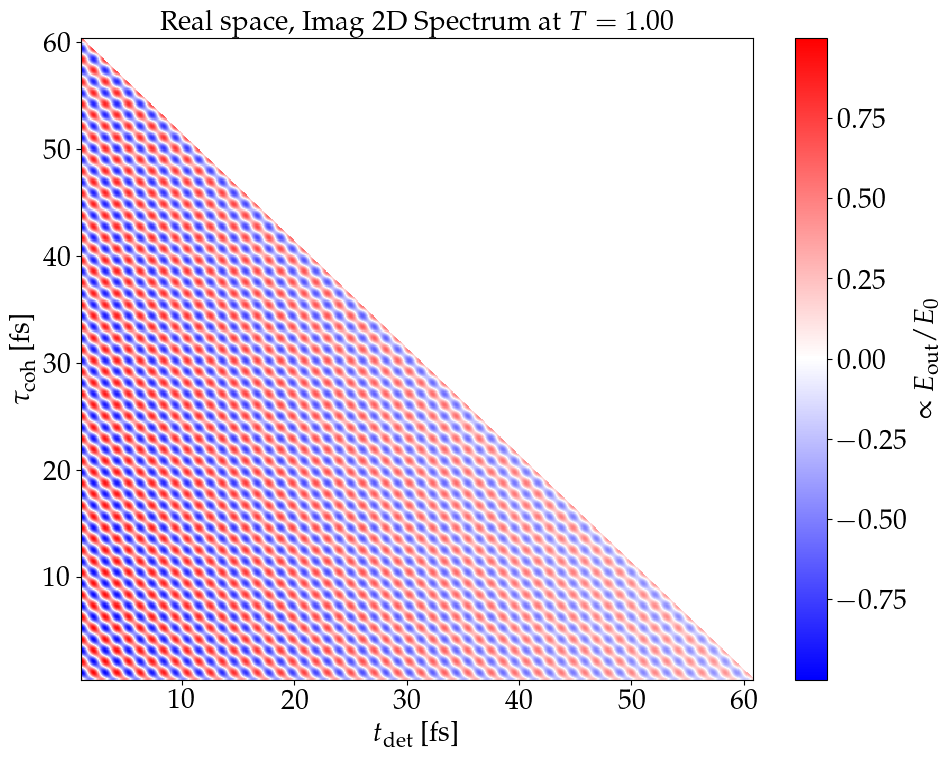

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


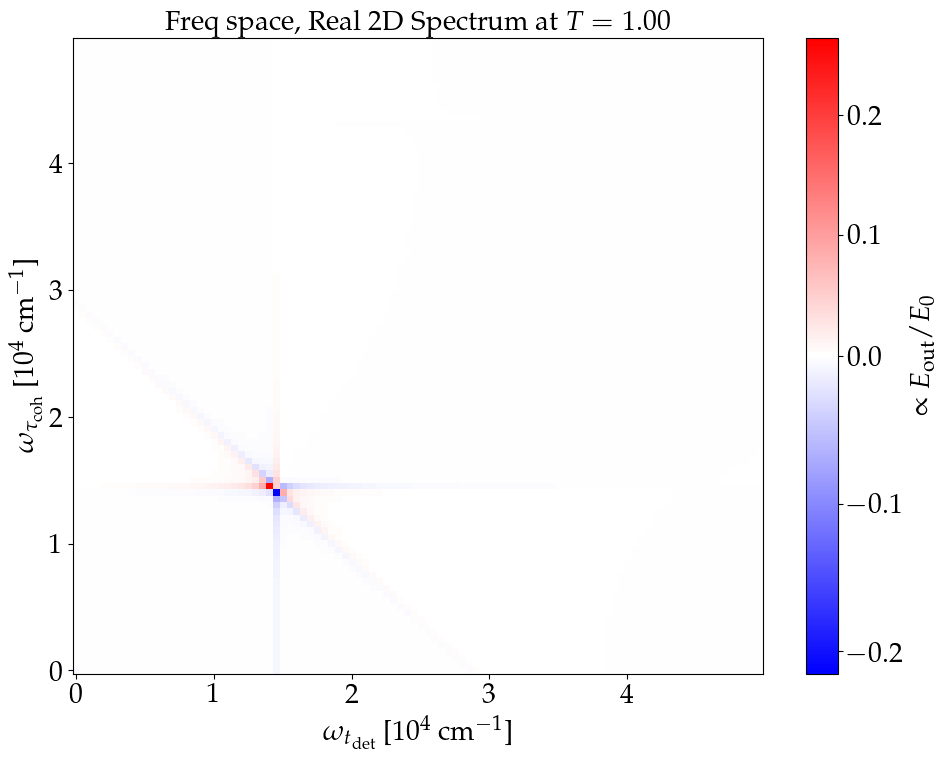

In [14]:
safe = False  # (**changeable**) decide if i want to save the plot to a svg file
positive = False  # (**changeable**) only plot one quadrant of the 2D-spectrum
use_custom_colormap=True,

section = (
    0, 5, # xmin, xmax,
    0, 5, # ymin, ymax
)

taus, ts, data = data_test_0[1], data_test_0[0], 1j*data_test_0[2] # because E ~ i*P

plot_positive_color_map(
    (ts, taus, data /np.abs(data).max()),
    positive=True,
    type="imag", # because E ~ i*P
    T_wait=T_test, 

    safe=safe,
    use_custom_colormap=use_custom_colormap,
)

# get back to wavenumber 
taufreqs = np.fft.fftshift(np.fft.fftfreq(len(taus), d=(taus[1] - taus[0]))) # freq f [cycle / fs]
tfreqs = np.fft.fftshift(np.fft.fftfreq(len(ts), d=(ts[1] - ts[0])))         # freq f [cycle / fs]
nu_tau = taufreqs * 3  # linear wavenumber = f / c[3 *10^-5 cm/fs] / 10^4    [10^4 cm⁻¹]
nu_t = tfreqs * 3      # linear wavenumber = f / c[3 *10^-5 cm/fs] / 10^4    [10^4 cm⁻¹]

s2d = np.fft.fftshift(
    np.fft.fft(                # FFT over t (exp(-i ω_t t))
        np.fft.ifft(np.imag(data), axis=0),  # iFFT over tau_coh (exp(+i ω_τ τ))
        axis=1
    ) # because E ~ i*P = i*<Dip_op>
)

plot_positive_color_map(
    (nu_t, nu_tau, s2d / np.max(np.abs(s2d))),
    positive=positive,
    type="real",
    space="freq",
    T_wait=T_test,
    safe=safe,
    use_custom_colormap=use_custom_colormap,
    section=section,
)

In [ ]:
print(rho_f.isherm)

ones_matrix = np.ones((4, 4))
rho_test = rho_1 # Qobj(ones_matrix)
# print("rho_test before: ", rho_test)
rho_modified = apply_RWA_phase_factors(rho_test, 0.1, omega=omega_laser)
print("after RWA: ", rho_modified)






t=1
phase_1 = np.exp(-1j * omega_laser * t)  # e^(-i * omega * t)

np.angle(phase_1), np.angle(np.conj(phase_1))

np.angle(rho_f.full()[0,1]), np.angle(rho_f.full()[1, 0])
rho_matrix = rho_1.full()
rho_1


# vizualize
test_args = get_pulse_args(0, 0, 0)

L = Liouville(test_args)  # what is this?
L
L_matrix = L(0)  # Get the operator at time t=0
print(L_matrix)
from qutip.visualization import matrix_histogram
matrix_histogram(L(0))

In [ ]:
# RESULTS from 2D Spectroscopy with all phases and times_T, already averaged over all phi
RESULT = get_all_results(phases, times_T)

In [ ]:
# Example usage
global_time_result, global_freq_result = extend_and_plot_results(RESULT)